### <Center> Лабораторна робота №9. <br> Оцінка інформативності ознак за допомогою градієнтного бустінгу

Детальних інструкцій не буде, завдання буде описано тезисно. Рекомендується використати метод Xgboost чи Catboost, та визначити інформативність ознак.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt



In [3]:
train = pd.read_csv('data/flight_delays_train.csv')
test = pd.read_csv('data/flight_delays_test.csv')

In [4]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [5]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Необхідно за часом вильоту літака, коду авіакомпанії-перевізника, місцю вильоту і прильоту і відстанню між аеропортами вильоту і прильоту зпрогнозувати затримку вильоту більше 15 хвилин. 

## Завдання 1. Створити вибірку :
* ознаки Distance і DepTime використати без змін;
* створити ознаку "маршрут" на  основі Origin та Dest;
* до ознак Month, DayofMonth, DayOfWeek, UniqueCarrier і "маршрут" застосувати OHE-перетворення (LabelBinarizer);

Створення нової ознаки "маршрут"


In [6]:
train['Route'] = train['Origin'] + "_" + train['Dest']
test['Route'] = test['Origin'] + "_" + test['Dest']

Виділяємо потрібні ознаки та цільову змінну


In [7]:
X_train = train[['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'DepTime', 'Distance', 'Route']]
y_train = (train['dep_delayed_15min'] == 'Y').astype(int)  # Перетворюємо на 0/1

X_test = test[['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'DepTime', 'Distance', 'Route']]

Визначення категоріальних ознак


In [8]:
categorical_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Route']

Застосовуємо OneHotEncoder для категоріальних ознак

In [9]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

Тренуємо OHE на тренувальних даних і застосовуємо до обох вибірок

In [10]:
X_train_cat = encoder.fit_transform(X_train[categorical_features])
X_test_cat = encoder.transform(X_test[categorical_features])

Отримуємо назви колонок після OHE


In [11]:
ohe_columns = encoder.get_feature_names_out(categorical_features)

Створюємо DataFrames із OHE-ознаками


In [12]:
X_train_cat_df = pd.DataFrame(X_train_cat, columns=ohe_columns)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=ohe_columns)

Додаємо числові ознаки до закодованих категоріальних


In [13]:
X_train_final = pd.concat([X_train_cat_df, X_train[['DepTime', 'Distance']].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_cat_df, X_test[['DepTime', 'Distance']].reset_index(drop=True)], axis=1)


Переконуємося, що колонки збігаються


In [14]:
X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)

Розділення даних і навчання моделі


In [15]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_final, y_train, test_size=0.2, random_state=42
)

Тренування XGBoost


In [16]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_split, y_train_split)

g:\Dev\intro_to_data_science\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:58:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Прогноз для валідаційної вибірки


In [17]:
y_val_pred = model.predict_proba(X_val_split)[:, 1]
val_auc = roc_auc_score(y_val_split, y_val_pred)
print(f"AUC на валідаційній вибірці: {val_auc:.4f}")


AUC на валідаційній вибірці: 0.7293


Прогноз для тестової вибірки


In [18]:
y_test_pred = model.predict_proba(X_test_final)[:, 1]

Збереження результатів

In [19]:
submission = pd.DataFrame({'id': test.index, 'dep_delayed_15min': y_test_pred})
submission.to_csv('submission.csv', index=False)

Перегляд результатів


In [20]:
submission.head()

,id,dep_delayed_15min
0,0,0.040982
1,1,0.034822
2,2,0.078073
3,3,0.177657
4,4,0.163390


## Завдання 2. Побудувати модель і оцінити інформативність ознак :
* побудувати модель на основі xgboost;
* налаштувати гіперпараметри з використанням крос-валідації;
* оцінити інформативність ознак.

In [21]:
# Цільова змінна
y_train = (train['dep_delayed_15min'] == 'Y').astype(int)

In [22]:
# Розбиваємо дані на навчальну та валідаційну вибірки
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_final, y_train, test_size=0.2, random_state=42
)

### 2.1 Налаштування гіперпараметрів через крос-валідацію:


 Гіперпараметри для пошуку


In [23]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}

 Використовуємо GridSearchCV для підбору параметрів


In [24]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [26]:
X_train_small, _, y_train_small, _ = train_test_split(X_train_split, y_train_split, train_size=0.1, random_state=42)

grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train_small, y_train_small)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


g:\Dev\intro_to_data_science\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

In [27]:
print(f"Найкращі параметри: {grid_search.best_params_}")
print(f"AUC на валідаційній вибірці: {grid_search.best_score_:.4f}")

Найкращі параметри: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
AUC на валідаційній вибірці: 0.7022


 Найкраща модель


In [28]:
best_model = grid_search.best_estimator_

### 2.2 Оцінка інформативності ознак:


 Оцінка важливості ознак


<Figure size 1200x800 with 0 Axes>

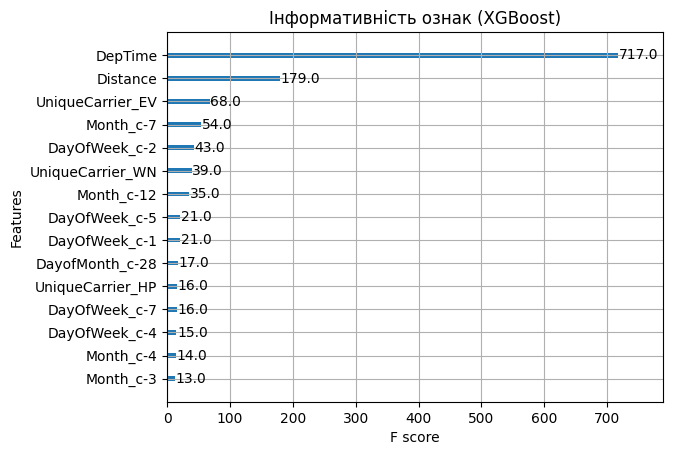

In [29]:
plt.figure(figsize=(12, 8))
plot_importance(best_model, max_num_features=15, importance_type='weight')
plt.title('Інформативність ознак (XGBoost)')
plt.show()